In [8]:
batches = {
    # "Data Processor": {"name": "data_processor", "batch_id": "7058_batch"},
    # "Model Converter": {"name": "model_converter", "batch_id": "7058_batch"},
    "Sketch Generator": {"name": "sketch_generator", "batch_id": "7058_batch"},
}

## Printing statistics


In [9]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # Add this import

# from tabulate import tabulate  # for nice table formatting


def calculate_stats(df, column):
    """Calculate basic statistics for a given column"""
    return {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
        "median": df[column].median(),
    }


# ... existing imports and calculate_stats function ...


def load_and_analyze_batch(batch_info, data_dir="processed_data"):
    """Analyze a single batch file"""
    input_csv = f"clean_{batch_info['name']}_{batch_info['batch_id']}.csv"
    df = pd.read_csv(f"{data_dir}/{input_csv}")

    stats = {}
    for column in ["total_tokens", "latency", "total_cost"]:
        metrics = calculate_stats(df, column)
        for metric_name, value in metrics.items():
            stats[f"{column}_{metric_name}"] = value

    stats["success_rate"] = (df["status"] == "success").mean() * 100
    return stats


# Collect all stats
all_stats = {}
if len(batches) > 1:  # If multiple batches
    for batch_name, batch_info in batches.items():
        all_stats[batch_name] = load_and_analyze_batch(batch_info)
else:  # If single batch
    batch_name, batch_info = next(iter(batches.items()))
    all_stats[batch_name] = load_and_analyze_batch(batch_info)


# Create DataFrame for nice display
df_stats = pd.DataFrame(all_stats).round(4)

# Organize metrics in groups
metric_groups = {
    "Total Tokens": [
        "total_tokens_average",
        "total_tokens_minimum",
        "total_tokens_maximum",
        "total_tokens_median",
    ],
    "Latency (s)": [
        "latency_average",
        "latency_minimum",
        "latency_maximum",
        "latency_median",
    ],
    # "Total Cost ($)": [
    #     "total_cost_average",
    #     "total_cost_minimum",
    #     "total_cost_maximum",
    #     "total_cost_median",
    # ],
    "Success Rate (%)": ["success_rate"],
}

# # Print formatted tables for each metric group
# for group_name, metrics in metric_groups.items():
#     print(f"\n{group_name}:")
#     subset_df = df_stats.loc[metrics]

#     # Clean up row names
#     subset_df.index = subset_df.index.str.split("_").str[-1]

#     print(tabulate(subset_df, headers="keys", tablefmt="pretty", floatfmt=".4f"))


# ... existing code ...

# Create DataFrame for nice display
df_stats = pd.DataFrame(all_stats).round(2)  # Changed from 4 to 2

# ... existing code ...

# Print formatted tables for each metric group
for group_name, metrics in metric_groups.items():
    print(f"\n{group_name}:")
    subset_df = df_stats.loc[metrics]

    # Clean up row names
    subset_df.index = subset_df.index.str.split("_").str[-1]

    print(
        tabulate(subset_df, headers="keys", tablefmt="pretty", floatfmt=".2f")
    )  # Changed from .4f to .2f


Total Tokens:
+---------+------------------+
|         | Sketch Generator |
+---------+------------------+
| average |     19076.96     |
| minimum |      1588.0      |
| maximum |     25593.0      |
| median  |     20727.0      |
+---------+------------------+

Latency (s):
+---------+------------------+
|         | Sketch Generator |
+---------+------------------+
| average |      44.11       |
| minimum |       3.55       |
| maximum |      65.36       |
| median  |      44.14       |
+---------+------------------+

Success Rate (%):
+------+------------------+
|      | Sketch Generator |
+------+------------------+
| rate |       30.0       |
+------+------------------+


## Another way of printing statistics in a table


In [10]:
def print_summary_table(batches, data_dir="processed_data"):
    # Headers
    print("\n=== Summary Across All Stages ===")
    print(
        "{:<20} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format(
            "Stage",
            "Avg Time(s)",
            "Min Time(s)",
            "Max Time(s)",
            "Avg Tokens",
            "Min Tokens",
            "Max Tokens",
            "Success(%)",
        )
    )
    print("-" * 104)

    # Process each batch
    for task_name, batch_info in batches.items():
        input_csv = f"clean_{batch_info['name']}_{batch_info['batch_id']}.csv"
        df = pd.read_csv(f"{data_dir}/{input_csv}")

        # Calculate statistics
        time_stats = calculate_stats(df, "latency")
        token_stats = calculate_stats(df, "total_tokens")
        success_rate = (df["status"] == "success").mean() * 100

        # Print row
        print(
            "{:<20} {:<12.2f} {:<12.2f} {:<12.2f} {:<12.0f} {:<12.0f} {:<12.0f} {:<12.2f}".format(
                task_name,
                time_stats["average"],
                time_stats["minimum"],
                time_stats["maximum"],
                token_stats["average"],
                token_stats["minimum"],
                token_stats["maximum"],
                success_rate,
            )
        )


# Print the summary table
print_summary_table(batches)


=== Summary Across All Stages ===
Stage                Avg Time(s)  Min Time(s)  Max Time(s)  Avg Tokens   Min Tokens   Max Tokens   Success(%)  
--------------------------------------------------------------------------------------------------------
Sketch Generator     44.11        3.55         65.36        19077        1588         25593        30.00       


## Print statistics regarding overall, success, and failure


In [11]:
import pandas as pd
import numpy as np


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        # Handle NaN values before converting to int
        return {k: int(v) if not pd.isna(v) else 0 for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["status"] == status]  # Changed from "pass" to "status"
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def print_stats_table(df, task_name):
    # Calculate stats
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(
        df, "success"
    )  # Changed from "yes" to "success"
    failed_stats = calculate_stats_by_status(
        df, "error"
    )  # Changed from "no" to "error"
    success_rate = (
        df["status"] == "success"
    ).mean() * 100  # Changed from "pass" to "status"

    print(f"\n=== {task_name} ===")
    print(
        "{:<15} {:<15} {:<12} {:<12} {:<12}".format(
            "Status", "Metric", "Average", "Minimum", "Maximum"
        )
    )
    print("-" * 66)

    # Create rows for latency
    for status, stats in [
        ("Overall", overall_stats),
        ("Success", passed_stats),
        ("Error", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "latency",
                stats["latency"]["average"],
                stats["latency"]["minimum"],
                stats["latency"]["maximum"],
            )
        )

    print()

    # Create rows for total_tokens
    for status, stats in [
        ("Overall", overall_stats),
        ("Success", passed_stats),
        ("Error", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "total_tokens",
                stats["total_tokens"]["average"],
                stats["total_tokens"]["minimum"],
                stats["total_tokens"]["maximum"],
            )
        )

    print(f"\nSuccess rate: {success_rate:.2f}%")


# # Define batches
# batches = {
#     "Data Processor": {"name": "data_processor", "batch_id": "2117_batch"},
#     "Model Converter": {"name": "model_converter", "batch_id": "7121_batch"},
#     "Sketch Generator": {"name": "sketch_generator", "batch_id": "1730_batch"},
# }

# Load and print stats for each batch
data_dir = "processed_data"
for task_name, batch_info in batches.items():
    input_csv = f"clean_{batch_info['name']}_{batch_info['batch_id']}.csv"
    df = pd.read_csv(f"{data_dir}/{input_csv}")
    print_stats_table(df, task_name)


=== Sketch Generator ===
Status          Metric          Average      Minimum      Maximum     
------------------------------------------------------------------
Overall         latency         44.11        3.55         65.36       
Success         latency         34.95        3.55         61.85       
Error           latency         48.04        37.77        65.36       

Overall         total_tokens    19076.00     1588.00      25593.00    
Success         total_tokens    14442.00     1588.00      23996.00    
Error           total_tokens    21063.00     15788.00     25593.00    

Success rate: 30.00%


## Plotting bar chart


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

"""REFERENCE FROM SCATTER PLOT:
title_fontweight = 800
label_fontweight = 600
tick_fontweight = 400
legend_fontweight = "normal"
legend_fontweight2 = "normal"

title_fontsize = 24
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16
"""

# Define plot styling variables
SUPTITLE_SIZE = 27
TITLE_SIZE = 22
TICK_LABEL_SIZE = 16
ANNOTATION_SIZE = 16  # New variable for bar value annotations
AXIS_LABEL_SIZE = 20  # New variable for axis labels
FONT_WEIGHT = "bold"

# Load all datasets
data_dir = "processed_data"
for key, info in batches.items():
    filename = f"clean_{info['name']}_{info['batch_id']}.csv"
    if key == "Sketch Generator":
        df_sketch_generator = pd.read_csv(f"{data_dir}/{filename}")
    elif key == "Data Processor":
        df_data_processor = pd.read_csv(f"{data_dir}/{filename}")
    elif key == "Model Conversion":
        df_model_converter = pd.read_csv(f"{data_dir}/{filename}")


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        # Handle NaN values before converting to int
        return {k: int(v) if not pd.isna(v) else 0 for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["status"] == status]  # Changed from "pass" to "status"
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def prepare_data_for_plot(df, task_name):
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(
        df, "success"
    )  # Changed from "yes" to "success"
    failed_stats = calculate_stats_by_status(
        df, "error"
    )  # Changed from "no" to "error"

    data = []
    for metric in ["latency", "total_tokens"]:
        for status, stats in [
            ("Overall", overall_stats),
            ("Passed runs", passed_stats),  # Changed label from "Passed" to "Success"
            ("Failed runs", failed_stats),  # Changed label from "Failed" to "Error"
        ]:
            data.append(
                {
                    "Task": task_name,
                    "Metric": metric,
                    "Status": status,
                    "Average": stats[metric]["average"],
                    "Minimum": stats[metric]["minimum"],
                    "Maximum": stats[metric]["maximum"],
                }
            )
    return pd.DataFrame(data)


# Prepare data for plotting
df_sketch = prepare_data_for_plot(df_sketch_generator, "Sketch Generation")
df_data = prepare_data_for_plot(df_data_processor, "Data Processing")
df_model = prepare_data_for_plot(df_model_converter, "Model Conversion")

# Combine all data
df_all = pd.concat([df_sketch, df_data, df_model])

# Determine global y-axis limits
latency_max = df_all[df_all["Metric"] == "latency"]["Average"].max()
tokens_max = df_all[df_all["Metric"] == "total_tokens"]["Average"].max()

# ... (keep the data loading and preparation code unchanged)

# Set the style
plt.style.use("ggplot")
sns.set_palette("muted")

# Plotting
tasks = df_all["Task"].unique()
fig, axes = plt.subplots(nrows=2, ncols=len(tasks), figsize=(16, 12), sharey="row")
plt.subplots_adjust(top=0.85)  # Add more space at the top


for col, task in enumerate(tasks):
    task_data = df_all[df_all["Task"] == task]

    # Plot latency
    ax_latency = axes[0, col]
    latency_data = task_data[task_data["Metric"] == "latency"]
    sns.barplot(
        x="Status",
        y="Average",
        data=latency_data,
        ax=ax_latency,
        hue="Status",
        palette="Blues_d",
        legend=False,
    )
    ax_latency.set_ylabel(
        "Time Consumption (seconds)" if col == 0 else "", fontsize=AXIS_LABEL_SIZE
    )
    ax_latency.set_ylim(0, latency_max * 1.1)
    ax_latency.set_title(
        task, fontsize=TITLE_SIZE, fontweight=FONT_WEIGHT, style="italic"
    )

    # Annotate latency bars
    for i, bar in enumerate(ax_latency.patches):
        yval = bar.get_height()
        ax_latency.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontweight=FONT_WEIGHT,
            fontsize=ANNOTATION_SIZE,
        )

    # Plot total tokens
    ax_tokens = axes[1, col]
    tokens_data = task_data[task_data["Metric"] == "total_tokens"]
    sns.barplot(
        x="Status",
        y="Average",
        data=tokens_data,
        ax=ax_tokens,
        hue="Status",
        palette="Greens_d",
        legend=False,
    )
    ax_tokens.set_ylabel(
        "Token Consumption (thousands)" if col == 0 else "", fontsize=AXIS_LABEL_SIZE
    )
    ax_tokens.set_ylim(0, tokens_max * 1.1)

    # Set y-axis ticks manually
    y_ticks = ax_tokens.get_yticks()
    ax_tokens.set_yticks(y_ticks)
    ax_tokens.set_yticklabels([f"{int(tick/1000)}" for tick in y_ticks])

    # Annotate token bars
    for i, bar in enumerate(ax_tokens.patches):
        yval = bar.get_height()
        ax_tokens.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval/1000:.2f}",
            ha="center",
            va="bottom",
            fontweight=FONT_WEIGHT,
            fontsize=ANNOTATION_SIZE,
        )

    # Improve readability
    for ax in [ax_latency, ax_tokens]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=TICK_LABEL_SIZE)
        ax.set_xlabel("")

# Add overall title
fig.suptitle(
    "Average Time and Token Consumption by Task Status",
    fontsize=SUPTITLE_SIZE,
    fontweight=FONT_WEIGHT,
    y=1,
)
plt.tight_layout()

plt.savefig(f"bar_plot.pdf", format="pdf", dpi=400, bbox_inches="tight")
# Adjust layout

plt.show()

NameError: name 'df_data_processor' is not defined

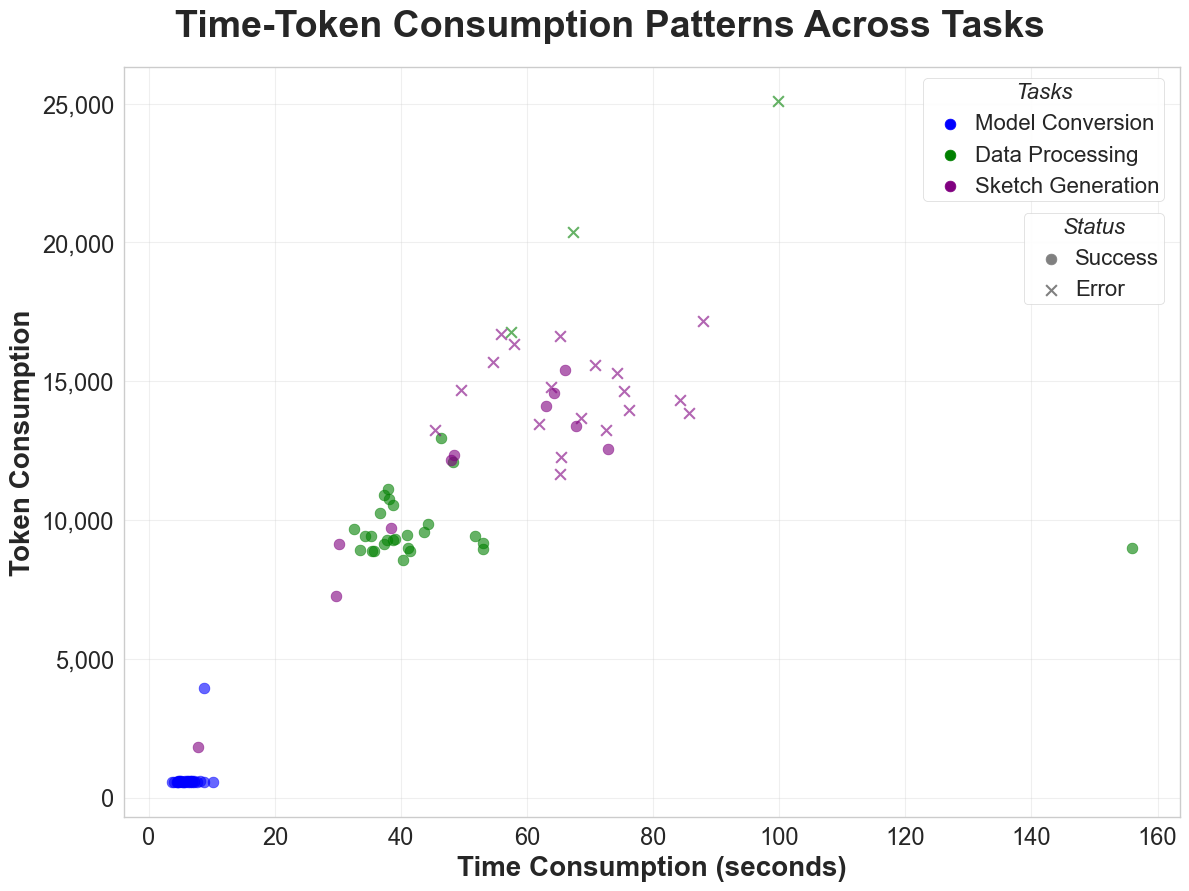

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

# Style parameters
title_fontweight = 800
label_fontweight = 600
tick_fontweight = 400
legend_fontweight = "normal"
legend_fontweight2 = "normal"

title_fontsize = 27
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# Define batches
# batches = {
#     "Sketch Generation": {"name": "sketch_generator", "batch_id": "7058_batch"},
#     "Data Processing": {"name": "data_processor", "batch_id": "7058_batch"},
#     "Model Conversion": {"name": "model_converter", "batch_id": "7058_batch"},
# }

# Load and combine data
data_dir = "processed_data"
dataframes = []

for task_name, batch_info in batches.items():
    input_csv = f"clean_{batch_info['name']}_{batch_info['batch_id']}.csv"
    df = pd.read_csv(f"{data_dir}/{input_csv}")
    df["task"] = task_name
    dataframes.append(df)

df_combined = pd.concat(dataframes)

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 9))

# Define colors for each task
task_colors = {
    "Model Conversion": "blue",
    "Data Processing": "green",
    "Sketch Generation": "purple",
}

# Plot each task with different colors and markers
for task, color in task_colors.items():
    task_data = df_combined[df_combined["task"] == task]

    # Plot successful runs
    success = task_data[task_data["status"] == "success"]
    plt.scatter(
        success["latency"],
        success["total_tokens"],
        color=color,
        alpha=0.6,
        label=task,
        marker="o",
        s=60,
    )

    # Plot failed runs
    failed = task_data[task_data["status"] == "error"]
    plt.scatter(
        failed["latency"],
        failed["total_tokens"],
        color=color,
        alpha=0.6,
        marker="x",
        s=60,
    )

# Labels and title
plt.xlabel(
    "Time Consumption (seconds)", fontsize=label_fontsize, fontweight=label_fontweight
)
plt.ylabel("Token Consumption", fontsize=label_fontsize, fontweight=label_fontweight)
plt.title(
    "Time-Token Consumption Patterns Across Tasks",
    fontsize=title_fontsize,
    loc="center",
    x=0.46,
    y=1.03,
    fontweight=title_fontweight,
)
plt.tick_params(axis="both", which="major", labelsize=17)

# Format axis numbers
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Create legend handles
task_handles = []
task_labels = []
status_handles = []
status_labels = []

# Collect task handles and labels
for task, color in task_colors.items():
    task_handles.append(plt.scatter([], [], color=color, marker="o", s=60))
    task_labels.append(task)

# Add status handles and labels
status_handles.append(plt.scatter([], [], color="gray", marker="o", s=60))
status_handles.append(plt.scatter([], [], color="gray", marker="x", s=60))
status_labels.extend(["Success", "Error"])

legend_title_prop = {
    "weight": legend_fontweight,
    "size": legend_fontsize,
    "style": "italic",
}

# Create legends
first_legend = plt.legend(
    task_handles,
    task_labels,
    loc="upper right",
    bbox_to_anchor=(0.995, 1.0),
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Tasks",
    title_fontproperties=legend_title_prop,
)

# Add the second legend for status markers
plt.gca().add_artist(first_legend)
plt.legend(
    status_handles,
    status_labels,
    loc="upper right",
    bbox_to_anchor=(0.995, 0.82),
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Status",
    title_fontproperties=legend_title_prop,
)

# Finishing touches
plt.grid(True, linestyle="-", alpha=0.3)
plt.tight_layout()
plt.savefig("scatter_plot.pdf", format="pdf", dpi=400)
plt.show()